# 🛢️ Well Production Simulation: Using Real Historical Data

This notebook demonstrates how to simulate wells using real data from:
- **Dimension Table** (`qi_di_b_factor_dimension.csv`): Well parameters (Qi, Di, b_factor, start_year)
- **Fact Table** (`houston_fact_combined_cleaned.csv`): Actual daily production records

## Workflow:
1. Get **Qi, Di, b_factor** from dimension table
2. Get **latest_production_date** from fact table
3. Calculate **days_on_production** = `latest_production_date - start_year`
4. Use actual production data where available
5. Simulate remaining forecast period using decline curve

```
|-------- Historical Data --------|-------- Forecast --------|
   start_year              latest_prod_date          sim_end_date
       ↓                         ↓                         ↓
   [Actual values from fact]  [Switch to decline curve simulation]
```

---
## 1. Setup & Imports

In [1]:
# Standard imports
import sys
import math
from pathlib import Path
from datetime import datetime, timedelta
from typing import Dict, List, Any, Optional

# Data analysis
import polars as pl
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Set up paths


# Configure display
pl.Config.set_tbl_rows(20)
pd.set_option('display.max_columns', 50)
pd.set_option('display.float_format', '{:,.2f}'.format)

# Matplotlib style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 11

print(" Standard imports loaded")

 Standard imports loaded


In [2]:
# Import simulation modules
from simulation import SimulationRunner, BasinModel, WellAgent
from config.simulation_config import (
    WellType, DeclineType, DriveMechanism, WellConfiguration,
    WELL_TYPE_PARAMETERS, CONSTANTS,
)
print(" Simulation modules loaded successfully!")

 Simulation modules loaded successfully!


---
## 2. Load Data

In [3]:
# Load dimension table (has Qi, Di, b_factor, start_year)
print(" Loading dimension data...")
dim = pl.read_csv("data\\qi_di_b_factor_dimension.csv")
print(f" Dimension table loaded: {dim.shape[0]:,} rows x {dim.shape[1]} columns")

print("\n Dimension Table Columns:")
for col in dim.columns:
    print(f"   - {col}")

 Loading dimension data...
 Dimension table loaded: 17,209 rows x 10 columns

 Dimension Table Columns:
   - country
   - market_id
   - basin_name
   - sub_basin_name
   - well_type
   - start_year
   - Qi
   - Di
   - model
   - b_factor


In [4]:
# Load fact table (has actual daily production)
print(" Loading fact data (this may take a moment for large file)...")
fact = pl.read_csv("data\\houston_fact_combined_cleaned.csv")
print(f" Fact table loaded: {fact.shape[0]:,} rows x {fact.shape[1]} columns")

print("\n Fact Table Columns:")
for col in fact.columns:
    print(f"   - {col}")

 Loading fact data (this may take a moment for large file)...
 Fact table loaded: 2,669,582 rows x 14 columns

 Fact Table Columns:
   - Unnamed: 0
   - api
   - basin
   - play_type
   - latest_production_date
   - production_vol_date
   - production_status
   - start_year
   - current_month
   - bopd
   - country
   - market_id
   - well_type
   - basin_name


In [5]:
# Explore dimension table structure
print(" DIMENSION TABLE - Sample Data:")
print("=" * 80)
dim.head(5)

 DIMENSION TABLE - Sample Data:


shape: (5, 10)
┌────────────┬───────────┬────────────┬────────────┬───┬─────────┬──────────┬───────────┬──────────┐
│ country    ┆ market_id ┆ basin_name ┆ sub_basin_ ┆ … ┆ Qi      ┆ Di       ┆ model     ┆ b_factor │
│ ---        ┆ ---       ┆ ---        ┆ name       ┆   ┆ ---     ┆ ---      ┆ ---       ┆ ---      │
│ str        ┆ str       ┆ str        ┆ ---        ┆   ┆ f64     ┆ f64      ┆ str       ┆ f64      │
│            ┆           ┆            ┆ str        ┆   ┆         ┆          ┆           ┆          │
╞════════════╪═══════════╪════════════╪════════════╪═══╪═════════╪══════════╪═══════════╪══════════╡
│ UNITED     ┆ null      ┆ null       ┆ null       ┆ … ┆ 10530.0 ┆ 0.862826 ┆ null      ┆ null     │
│ STATES OF  ┆           ┆            ┆            ┆   ┆         ┆          ┆           ┆          │
│ AMERICA    ┆           ┆            ┆            ┆   ┆         ┆          ┆           ┆          │
│ UNITED     ┆ null      ┆ null       ┆ null       ┆ … ┆ 7343.5  ┆ 0.452474 ┆ hyperboli ┆ 0.45     │
│ STATES OF  ┆           ┆            ┆            ┆   ┆         ┆          ┆ c         ┆          │
│ AMERICA    ┆           ┆            ┆            ┆   ┆         ┆          ┆           ┆          │
│ UNITED     ┆ null      ┆ null       ┆ null       ┆ … ┆ 7343.5  ┆ 0.452474 ┆ exponenti ┆ 0.025    │
│ STATES OF  ┆           ┆            ┆            ┆   ┆         ┆          ┆ al        ┆          │
│ AMERICA    ┆           ┆            ┆            ┆   ┆         ┆          ┆           ┆          │
│ UNITED     ┆ null      ┆ null       ┆ null       ┆ … ┆ 7343.5  ┆ 0.452474 ┆ harmonic  ┆ 1.0      │
│ STATES OF  ┆           ┆            ┆            ┆   ┆         ┆          ┆           ┆          │
│ AMERICA    ┆           ┆            ┆            ┆   ┆         ┆          ┆           ┆          │
│ UNITED     ┆ Cushing   ┆ AMARILLO   ┆ AMARILLO   ┆ … ┆ 674.5   ┆ 1.608565 ┆ hyperboli ┆ 0.45     │
│ STATES OF  ┆           ┆ UPLIFT     ┆ UPLIFT     ┆   ┆         ┆          ┆ c         ┆          │
│ AMERICA    ┆           ┆            ┆            ┆   ┆         ┆          ┆           ┆          │
└────────────┴───────────┴────────────┴────────────┴───┴─────────┴──────────┴───────────┴──────────┘

In [6]:
# Explore fact table structure
print(" FACT TABLE - Sample Data:")
print("=" * 80)
fact.head(5)

 FACT TABLE - Sample Data:


shape: (5, 14)
┌────────────┬────────────┬───────┬────────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ Unnamed: 0 ┆ api        ┆ basin ┆ play_type  ┆ … ┆ country   ┆ market_id ┆ well_type ┆ basin_nam │
│ ---        ┆ ---        ┆ ---   ┆ ---        ┆   ┆ ---       ┆ ---       ┆ ---       ┆ e         │
│ i64        ┆ i64        ┆ str   ┆ str        ┆   ┆ str       ┆ str       ┆ str       ┆ ---       │
│            ┆            ┆       ┆            ┆   ┆           ┆           ┆           ┆ str       │
╞════════════╪════════════╪═══════╪════════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 1967147    ┆ 4201500075 ┆ GULF  ┆ CONVENTION ┆ … ┆ UNITED    ┆ Houston   ┆ CONVENTIO ┆ GULF      │
│            ┆ 0000       ┆ COAST ┆ AL ONSHORE ┆   ┆ STATES OF ┆           ┆ NAL       ┆ COAST     │
│            ┆            ┆ BASIN ┆            ┆   ┆ AMERICA   ┆           ┆ ONSHORE   ┆ BASIN     │
│ 1967148    ┆ 4201500075 ┆ GULF  ┆ CONVENTION ┆ … ┆ UNITED    ┆ Houston   ┆ CONVENTIO ┆ GULF      │
│            ┆ 0000       ┆ COAST ┆ AL ONSHORE ┆   ┆ STATES OF ┆           ┆ NAL       ┆ COAST     │
│            ┆            ┆ BASIN ┆            ┆   ┆ AMERICA   ┆           ┆ ONSHORE   ┆ BASIN     │
│ 1967149    ┆ 4201500075 ┆ GULF  ┆ CONVENTION ┆ … ┆ UNITED    ┆ Houston   ┆ CONVENTIO ┆ GULF      │
│            ┆ 0000       ┆ COAST ┆ AL ONSHORE ┆   ┆ STATES OF ┆           ┆ NAL       ┆ COAST     │
│            ┆            ┆ BASIN ┆            ┆   ┆ AMERICA   ┆           ┆ ONSHORE   ┆ BASIN     │
│ 1967150    ┆ 4201500075 ┆ GULF  ┆ CONVENTION ┆ … ┆ UNITED    ┆ Houston   ┆ CONVENTIO ┆ GULF      │
│            ┆ 0000       ┆ COAST ┆ AL ONSHORE ┆   ┆ STATES OF ┆           ┆ NAL       ┆ COAST     │
│            ┆            ┆ BASIN ┆            ┆   ┆ AMERICA   ┆           ┆ ONSHORE   ┆ BASIN     │
│ 1967151    ┆ 4201500075 ┆ GULF  ┆ CONVENTION ┆ … ┆ UNITED    ┆ Houston   ┆ CONVENTIO ┆ GULF      │
│            ┆ 0000       ┆ COAST ┆ AL ONSHORE ┆   ┆ STATES OF ┆           ┆ NAL       ┆ COAST     │
│            ┆            ┆ BASIN ┆            ┆   ┆ AMERICA   ┆           ┆ ONSHORE   ┆ BASIN     │
└────────────┴────────────┴───────┴────────────┴───┴───────────┴───────────┴───────────┴───────────┘

---
## 3. Get Well Summary from Fact Table

For each well (API), find:
- First production date
- **Latest production date** (when actual data ends)
- Total days of data

In [7]:
# Convert date strings to dates and get per-well summary
fact_with_dates = fact.with_columns([
    pl.col('production_vol_date').str.to_date().alias('prod_date')
])

# Get summary for each well
well_summary = (
    fact_with_dates
    .group_by('api')
    .agg([
        pl.col('prod_date').min().alias('first_prod_date'),
        pl.col('prod_date').max().alias('latest_prod_date'),  # KEY: When actual data ends
        pl.col('bopd').first().alias('first_bopd'),
        pl.col('bopd').last().alias('last_bopd'),  # Last known production
        pl.col('bopd').mean().alias('avg_bopd'),
        pl.col('bopd').max().alias('max_bopd'),
        pl.col('bopd').sum().alias('total_oil'),
        pl.col('play_type').first().alias('play_type'),
        pl.col('basin').first().alias('basin'),
        pl.col('production_status').last().alias('status'),
        pl.len().alias('days_of_data'),
        pl.col("start_year").min().alias("start_year")  # Number of days with actual data
    ])
    .sort('total_oil', descending=True)
)

print(f" Total unique wells: {well_summary.shape[0]:,}")
print("\n Top 10 wells by total production:")
well_summary.head(10)

 Total unique wells: 1,563

 Top 10 wells by total production:


shape: (10, 13)
┌────────────┬────────────┬────────────┬────────────┬───┬───────┬────────┬────────────┬────────────┐
│ api        ┆ first_prod ┆ latest_pro ┆ first_bopd ┆ … ┆ basin ┆ status ┆ days_of_da ┆ start_year │
│ ---        ┆ _date      ┆ d_date     ┆ ---        ┆   ┆ ---   ┆ ---    ┆ ta         ┆ ---        │
│ i64        ┆ ---        ┆ ---        ┆ f64        ┆   ┆ str   ┆ str    ┆ ---        ┆ i64        │
│            ┆ date       ┆ date       ┆            ┆   ┆       ┆        ┆ u32        ┆            │
╞════════════╪════════════╪════════════╪════════════╪═══╪═══════╪════════╪════════════╪════════════╡
│ 4270640427 ┆ 2020-01-01 ┆ 2025-09-30 ┆ 816.709677 ┆ … ┆ GULF  ┆ ACTIVE ┆ 2008       ┆ 2010       │
│ 0002       ┆            ┆            ┆            ┆   ┆ COAST ┆        ┆            ┆            │
│            ┆            ┆            ┆            ┆   ┆ BASIN ┆        ┆            ┆            │
│ 4270640478 ┆ 2022-03-01 ┆ 2025-09-30 ┆ 723.612903 ┆ … ┆ GULF  ┆ ACTIVE ┆ 1310       ┆ 2022       │
│ 0200       ┆            ┆            ┆            ┆   ┆ COAST ┆        ┆            ┆            │
│            ┆            ┆            ┆            ┆   ┆ BASIN ┆        ┆            ┆            │
│ 4220132988 ┆ 2021-07-01 ┆ 2025-03-31 ┆ 737.774194 ┆ … ┆ GULF  ┆ ACTIVE ┆ 1370       ┆ 2021       │
│ 0000       ┆            ┆            ┆            ┆   ┆ COAST ┆        ┆            ┆            │
│            ┆            ┆            ┆            ┆   ┆ BASIN ┆        ┆            ┆            │
│ 4203933304 ┆ 2020-01-01 ┆ 2025-09-30 ┆ 439.709677 ┆ … ┆ GULF  ┆ ACTIVE ┆ 2100       ┆ 2018       │
│ 0000       ┆            ┆            ┆            ┆   ┆ COAST ┆        ┆            ┆            │
│            ┆            ┆            ┆            ┆   ┆ BASIN ┆        ┆            ┆            │
│ 4220132986 ┆ 2021-05-01 ┆ 2025-03-31 ┆ 449.483871 ┆ … ┆ GULF  ┆ ACTIVE ┆ 1431       ┆ 2021       │
│ 0000       ┆            ┆            ┆            ┆   ┆ COAST ┆        ┆            ┆            │
│            ┆            ┆            ┆            ┆   ┆ BASIN ┆        ┆            ┆            │
│ 4270640476 ┆ 2022-04-01 ┆ 2025-09-30 ┆ 266.233333 ┆ … ┆ GULF  ┆ ACTIVE ┆ 1279       ┆ 2022       │
│ 0600       ┆            ┆            ┆            ┆   ┆ COAST ┆        ┆            ┆            │
│            ┆            ┆            ┆            ┆   ┆ BASIN ┆        ┆            ┆            │
│ 4203933080 ┆ 2020-01-01 ┆ 2025-06-30 ┆ 202.612903 ┆ … ┆ GULF  ┆ ACTIVE ┆ 2008       ┆ 2014       │
│ 0000       ┆            ┆            ┆            ┆   ┆ COAST ┆        ┆            ┆            │
│            ┆            ┆            ┆            ┆   ┆ BASIN ┆        ┆            ┆            │
│ 4203901118 ┆ 2020-01-01 ┆ 2025-06-30 ┆ 254.870968 ┆ … ┆ GULF  ┆ ACTIVE ┆ 2008       ┆ 2008       │
│ 0000       ┆            ┆            ┆            ┆   ┆ COAST ┆        ┆            ┆            │
│            ┆            ┆            ┆            ┆   ┆ BASIN ┆        ┆            ┆            │
│ 4203901084 ┆ 2020-01-01 ┆ 2025-06-30 ┆ 177.096774 ┆ … ┆ GULF  ┆ ACTIVE ┆ 2008       ┆ 2008       │
│ 0000       ┆            ┆            ┆            ┆   ┆ COAST ┆        ┆            ┆            │
│            ┆            ┆            ┆            ┆   ┆ BASIN ┆        ┆            ┆            │
│ 4203901060 ┆ 2020-01-01 ┆ 2025-06-30 ┆ 164.0      ┆ … ┆ GULF  ┆ ACTIVE ┆ 2008       ┆ 2010       │
│ 0000       ┆            ┆            ┆            ┆   ┆ COAST ┆        ┆            ┆            │
│            ┆            ┆            ┆            ┆   ┆ BASIN ┆        ┆            ┆            │
└────────────┴────────────┴────────────┴────────────┴───┴───────┴────────┴────────────┴────────────┘

---
## 4. Merge with Dimension Table

Get Qi, Di, b_factor, and start_year from dimension table.

In [8]:
# Check what columns are in dimension table that we need
print(" Looking for key columns in dimension table...")
print(f"\nAll columns: {dim.columns}")

# Find the API/well identifier column
api_cols = [c for c in dim.columns if 'api' in c.lower() or 'well' in c.lower() or 'id' in c.lower()]
print(f"\nPossible API columns: {api_cols}")

# Find Qi/Di/b_factor columns
qi_cols = [c for c in dim.columns if 'qi' in c.lower() or 'initial' in c.lower()]
di_cols = [c for c in dim.columns if 'di' in c.lower() or 'decline' in c.lower()]
b_cols = [c for c in dim.columns if 'b_' in c.lower() or 'bfactor' in c.lower()]
year_cols = [c for c in dim.columns if 'year' in c.lower() or 'start' in c.lower() or 'date' in c.lower()]

print(f"\nQi columns: {qi_cols}")
print(f"Di columns: {di_cols}")
print(f"b_factor columns: {b_cols}")
print(f"Year/Date columns: {year_cols}")

 Looking for key columns in dimension table...

All columns: ['country', 'market_id', 'basin_name', 'sub_basin_name', 'well_type', 'start_year', 'Qi', 'Di', 'model', 'b_factor']

Possible API columns: ['market_id', 'well_type']

Qi columns: ['Qi']
Di columns: ['Di']
b_factor columns: ['sub_basin_name', 'b_factor']
Year/Date columns: ['start_year']


In [9]:
# Show sample of dimension data to identify the exact column names
print(" Dimension table sample with all columns:")
dim.head(3)

 Dimension table sample with all columns:


shape: (3, 10)
┌────────────┬───────────┬────────────┬────────────┬───┬─────────┬──────────┬───────────┬──────────┐
│ country    ┆ market_id ┆ basin_name ┆ sub_basin_ ┆ … ┆ Qi      ┆ Di       ┆ model     ┆ b_factor │
│ ---        ┆ ---       ┆ ---        ┆ name       ┆   ┆ ---     ┆ ---      ┆ ---       ┆ ---      │
│ str        ┆ str       ┆ str        ┆ ---        ┆   ┆ f64     ┆ f64      ┆ str       ┆ f64      │
│            ┆           ┆            ┆ str        ┆   ┆         ┆          ┆           ┆          │
╞════════════╪═══════════╪════════════╪════════════╪═══╪═════════╪══════════╪═══════════╪══════════╡
│ UNITED     ┆ null      ┆ null       ┆ null       ┆ … ┆ 10530.0 ┆ 0.862826 ┆ null      ┆ null     │
│ STATES OF  ┆           ┆            ┆            ┆   ┆         ┆          ┆           ┆          │
│ AMERICA    ┆           ┆            ┆            ┆   ┆         ┆          ┆           ┆          │
│ UNITED     ┆ null      ┆ null       ┆ null       ┆ … ┆ 7343.5  ┆ 0.452474 ┆ hyperboli ┆ 0.45     │
│ STATES OF  ┆           ┆            ┆            ┆   ┆         ┆          ┆ c         ┆          │
│ AMERICA    ┆           ┆            ┆            ┆   ┆         ┆          ┆           ┆          │
│ UNITED     ┆ null      ┆ null       ┆ null       ┆ … ┆ 7343.5  ┆ 0.452474 ┆ exponenti ┆ 0.025    │
│ STATES OF  ┆           ┆            ┆            ┆   ┆         ┆          ┆ al        ┆          │
│ AMERICA    ┆           ┆            ┆            ┆   ┆         ┆          ┆           ┆          │
└────────────┴───────────┴────────────┴────────────┴───┴─────────┴──────────┴───────────┴──────────┘

In [10]:
# Define column mappings based on what we found
# (Update these based on actual column names in your dimension table)
keys = ["country","market_id","basin_name","well_type","start_year"]
all_columns = ["country","market_id","basin_name","sub_basin_name","well_type","start_year","Qi","Di","model","b_factor"]


In [11]:
# Select the columns we need from dimension table
dim_subset = dim.select(all_columns)


print(" Dimension subset:")
dim_subset.head(5)

 Dimension subset:


shape: (5, 10)
┌────────────┬───────────┬────────────┬────────────┬───┬─────────┬──────────┬───────────┬──────────┐
│ country    ┆ market_id ┆ basin_name ┆ sub_basin_ ┆ … ┆ Qi      ┆ Di       ┆ model     ┆ b_factor │
│ ---        ┆ ---       ┆ ---        ┆ name       ┆   ┆ ---     ┆ ---      ┆ ---       ┆ ---      │
│ str        ┆ str       ┆ str        ┆ ---        ┆   ┆ f64     ┆ f64      ┆ str       ┆ f64      │
│            ┆           ┆            ┆ str        ┆   ┆         ┆          ┆           ┆          │
╞════════════╪═══════════╪════════════╪════════════╪═══╪═════════╪══════════╪═══════════╪══════════╡
│ UNITED     ┆ null      ┆ null       ┆ null       ┆ … ┆ 10530.0 ┆ 0.862826 ┆ null      ┆ null     │
│ STATES OF  ┆           ┆            ┆            ┆   ┆         ┆          ┆           ┆          │
│ AMERICA    ┆           ┆            ┆            ┆   ┆         ┆          ┆           ┆          │
│ UNITED     ┆ null      ┆ null       ┆ null       ┆ … ┆ 7343.5  ┆ 0.452474 ┆ hyperboli ┆ 0.45     │
│ STATES OF  ┆           ┆            ┆            ┆   ┆         ┆          ┆ c         ┆          │
│ AMERICA    ┆           ┆            ┆            ┆   ┆         ┆          ┆           ┆          │
│ UNITED     ┆ null      ┆ null       ┆ null       ┆ … ┆ 7343.5  ┆ 0.452474 ┆ exponenti ┆ 0.025    │
│ STATES OF  ┆           ┆            ┆            ┆   ┆         ┆          ┆ al        ┆          │
│ AMERICA    ┆           ┆            ┆            ┆   ┆         ┆          ┆           ┆          │
│ UNITED     ┆ null      ┆ null       ┆ null       ┆ … ┆ 7343.5  ┆ 0.452474 ┆ harmonic  ┆ 1.0      │
│ STATES OF  ┆           ┆            ┆            ┆   ┆         ┆          ┆           ┆          │
│ AMERICA    ┆           ┆            ┆            ┆   ┆         ┆          ┆           ┆          │
│ UNITED     ┆ Cushing   ┆ AMARILLO   ┆ AMARILLO   ┆ … ┆ 674.5   ┆ 1.608565 ┆ hyperboli ┆ 0.45     │
│ STATES OF  ┆           ┆ UPLIFT     ┆ UPLIFT     ┆   ┆         ┆          ┆ c         ┆          │
│ AMERICA    ┆           ┆            ┆            ┆   ┆         ┆          ┆           ┆          │
└────────────┴───────────┴────────────┴────────────┴───┴─────────┴──────────┴───────────┴──────────┘

In [12]:
well_summary=well_summary.with_columns(pl.lit("UNITED STATES OF AMERICA").alias("country"),
                          pl.lit("Houston").alias("market_id"))

well_summary=well_summary.rename({"play_type":"well_type", "basin":"basin_name"})

In [13]:
well_summary.join(dim_subset, on=keys, how='left').null_count()

shape: (1, 20)
┌─────┬─────────────────┬──────────────────┬────────────┬───┬─────┬─────┬───────┬──────────┐
│ api ┆ first_prod_date ┆ latest_prod_date ┆ first_bopd ┆ … ┆ Qi  ┆ Di  ┆ model ┆ b_factor │
│ --- ┆ ---             ┆ ---              ┆ ---        ┆   ┆ --- ┆ --- ┆ ---   ┆ ---      │
│ u32 ┆ u32             ┆ u32              ┆ u32        ┆   ┆ u32 ┆ u32 ┆ u32   ┆ u32      │
╞═════╪═════════════════╪══════════════════╪════════════╪═══╪═════╪═════╪═══════╪══════════╡
│ 0   ┆ 0               ┆ 0                ┆ 0          ┆ … ┆ 0   ┆ 0   ┆ 0     ┆ 0        │
└─────┴─────────────────┴──────────────────┴────────────┴───┴─────┴─────┴───────┴──────────┘

In [14]:
# Merge well summary with dimension data
# This gives us: actual data dates + decline curve parameters
well_summary.rename({
    
})
wells_merged = well_summary.join(
    dim_subset,
    on=keys,
    how='left'
)
print(wells_merged.columns)

print(f" Merged wells: {wells_merged.shape[0]:,}")
print(f"   With Qi data: {wells_merged.filter(pl.col('Qi').is_not_null()).shape[0]:,}")

# Filter to wells that have both fact and dimension data
wells_with_params = wells_merged.filter(
    pl.col('Qi').is_not_null() & 
    pl.col('Di').is_not_null() &
    (pl.col('Qi') > 0)
)

print(f"   Wells with complete params: {wells_with_params.shape[0]:,}")
wells_with_params.head(10)

['api', 'first_prod_date', 'latest_prod_date', 'first_bopd', 'last_bopd', 'avg_bopd', 'max_bopd', 'total_oil', 'well_type', 'basin_name', 'status', 'days_of_data', 'start_year', 'country', 'market_id', 'sub_basin_name', 'Qi', 'Di', 'model', 'b_factor']
 Merged wells: 4,689
   With Qi data: 4,689
   Wells with complete params: 4,689


shape: (10, 20)
┌────────────┬────────────┬───────────┬───────────┬───┬──────────┬──────────┬───────────┬──────────┐
│ api        ┆ first_prod ┆ latest_pr ┆ first_bop ┆ … ┆ Qi       ┆ Di       ┆ model     ┆ b_factor │
│ ---        ┆ _date      ┆ od_date   ┆ d         ┆   ┆ ---      ┆ ---      ┆ ---       ┆ ---      │
│ i64        ┆ ---        ┆ ---       ┆ ---       ┆   ┆ f64      ┆ f64      ┆ str       ┆ f64      │
│            ┆ date       ┆ date      ┆ f64       ┆   ┆          ┆          ┆           ┆          │
╞════════════╪════════════╪═══════════╪═══════════╪═══╪══════════╪══════════╪═══════════╪══════════╡
│ 4270640427 ┆ 2020-01-01 ┆ 2025-09-3 ┆ 816.70967 ┆ … ┆ 1433.25  ┆ 0.006944 ┆ hyperboli ┆ 0.35     │
│ 0002       ┆            ┆ 0         ┆ 7         ┆   ┆          ┆          ┆ c         ┆          │
│ 4270640427 ┆ 2020-01-01 ┆ 2025-09-3 ┆ 816.70967 ┆ … ┆ 1433.25  ┆ 0.006944 ┆ exponenti ┆ 0.025    │
│ 0002       ┆            ┆ 0         ┆ 7         ┆   ┆          ┆          ┆ al        ┆          │
│ 4270640427 ┆ 2020-01-01 ┆ 2025-09-3 ┆ 816.70967 ┆ … ┆ 1433.25  ┆ 0.006944 ┆ harmonic  ┆ 1.0      │
│ 0002       ┆            ┆ 0         ┆ 7         ┆   ┆          ┆          ┆           ┆          │
│ 4270640478 ┆ 2022-03-01 ┆ 2025-09-3 ┆ 723.61290 ┆ … ┆ 18608.75 ┆ 0.904006 ┆ hyperboli ┆ 0.35     │
│ 0200       ┆            ┆ 0         ┆ 3         ┆   ┆          ┆          ┆ c         ┆          │
│ 4270640478 ┆ 2022-03-01 ┆ 2025-09-3 ┆ 723.61290 ┆ … ┆ 18608.75 ┆ 0.904006 ┆ exponenti ┆ 0.025    │
│ 0200       ┆            ┆ 0         ┆ 3         ┆   ┆          ┆          ┆ al        ┆          │
│ 4270640478 ┆ 2022-03-01 ┆ 2025-09-3 ┆ 723.61290 ┆ … ┆ 18608.75 ┆ 0.904006 ┆ harmonic  ┆ 1.0      │
│ 0200       ┆            ┆ 0         ┆ 3         ┆   ┆          ┆          ┆           ┆          │
│ 4220132988 ┆ 2021-07-01 ┆ 2025-03-3 ┆ 737.77419 ┆ … ┆ 2374.25  ┆ 0.45251  ┆ hyperboli ┆ 0.45     │
│ 0000       ┆            ┆ 1         ┆ 4         ┆   ┆          ┆          ┆ c         ┆          │
│ 4220132988 ┆ 2021-07-01 ┆ 2025-03-3 ┆ 737.77419 ┆ … ┆ 2374.25  ┆ 0.45251  ┆ exponenti ┆ 0.025    │
│ 0000       ┆            ┆ 1         ┆ 4         ┆   ┆          ┆          ┆ al        ┆          │
│ 4220132988 ┆ 2021-07-01 ┆ 2025-03-3 ┆ 737.77419 ┆ … ┆ 2374.25  ┆ 0.45251  ┆ harmonic  ┆ 1.0      │
│ 0000       ┆            ┆ 1         ┆ 4         ┆   ┆          ┆          ┆           ┆          │
│ 4203933304 ┆ 2020-01-01 ┆ 2025-09-3 ┆ 439.70967 ┆ … ┆ 2201.0   ┆ 0.551675 ┆ hyperboli ┆ 0.45     │
│ 0000       ┆            ┆ 0         ┆ 7         ┆   ┆          ┆          ┆ c         ┆          │
└────────────┴────────────┴───────────┴───────────┴───┴──────────┴──────────┴───────────┴──────────┘

In [15]:
wells_merged

shape: (4_689, 20)
┌────────────┬────────────┬───────────┬───────────┬───┬──────────┬──────────┬───────────┬──────────┐
│ api        ┆ first_prod ┆ latest_pr ┆ first_bop ┆ … ┆ Qi       ┆ Di       ┆ model     ┆ b_factor │
│ ---        ┆ _date      ┆ od_date   ┆ d         ┆   ┆ ---      ┆ ---      ┆ ---       ┆ ---      │
│ i64        ┆ ---        ┆ ---       ┆ ---       ┆   ┆ f64      ┆ f64      ┆ str       ┆ f64      │
│            ┆ date       ┆ date      ┆ f64       ┆   ┆          ┆          ┆           ┆          │
╞════════════╪════════════╪═══════════╪═══════════╪═══╪══════════╪══════════╪═══════════╪══════════╡
│ 4270640427 ┆ 2020-01-01 ┆ 2025-09-3 ┆ 816.70967 ┆ … ┆ 1433.25  ┆ 0.006944 ┆ hyperboli ┆ 0.35     │
│ 0002       ┆            ┆ 0         ┆ 7         ┆   ┆          ┆          ┆ c         ┆          │
│ 4270640427 ┆ 2020-01-01 ┆ 2025-09-3 ┆ 816.70967 ┆ … ┆ 1433.25  ┆ 0.006944 ┆ exponenti ┆ 0.025    │
│ 0002       ┆            ┆ 0         ┆ 7         ┆   ┆          ┆          ┆ al        ┆          │
│ 4270640427 ┆ 2020-01-01 ┆ 2025-09-3 ┆ 816.70967 ┆ … ┆ 1433.25  ┆ 0.006944 ┆ harmonic  ┆ 1.0      │
│ 0002       ┆            ┆ 0         ┆ 7         ┆   ┆          ┆          ┆           ┆          │
│ 4270640478 ┆ 2022-03-01 ┆ 2025-09-3 ┆ 723.61290 ┆ … ┆ 18608.75 ┆ 0.904006 ┆ hyperboli ┆ 0.35     │
│ 0200       ┆            ┆ 0         ┆ 3         ┆   ┆          ┆          ┆ c         ┆          │
│ 4270640478 ┆ 2022-03-01 ┆ 2025-09-3 ┆ 723.61290 ┆ … ┆ 18608.75 ┆ 0.904006 ┆ exponenti ┆ 0.025    │
│ 0200       ┆            ┆ 0         ┆ 3         ┆   ┆          ┆          ┆ al        ┆          │
│ 4270640478 ┆ 2022-03-01 ┆ 2025-09-3 ┆ 723.61290 ┆ … ┆ 18608.75 ┆ 0.904006 ┆ harmonic  ┆ 1.0      │
│ 0200       ┆            ┆ 0         ┆ 3         ┆   ┆          ┆          ┆           ┆          │
│ 4220132988 ┆ 2021-07-01 ┆ 2025-03-3 ┆ 737.77419 ┆ … ┆ 2374.25  ┆ 0.45251  ┆ hyperboli ┆ 0.45     │
│ 0000       ┆            ┆ 1         ┆ 4         ┆   ┆          ┆          ┆ c         ┆          │
│ 4220132988 ┆ 2021-07-01 ┆ 2025-03-3 ┆ 737.77419 ┆ … ┆ 2374.25  ┆ 0.45251  ┆ exponenti ┆ 0.025    │
│ 0000       ┆            ┆ 1         ┆ 4         ┆   ┆          ┆          ┆ al        ┆          │
│ 4220132988 ┆ 2021-07-01 ┆ 2025-03-3 ┆ 737.77419 ┆ … ┆ 2374.25  ┆ 0.45251  ┆ harmonic  ┆ 1.0      │
│ 0000       ┆            ┆ 1         ┆ 4         ┆   ┆          ┆          ┆           ┆          │
│ 4203933304 ┆ 2020-01-01 ┆ 2025-09-3 ┆ 439.70967 ┆ … ┆ 2201.0   ┆ 0.551675 ┆ hyperboli ┆ 0.45     │
│ 0000       ┆            ┆ 0         ┆ 7         ┆   ┆          ┆          ┆ c         ┆          │
│ …          ┆ …          ┆ …         ┆ …         ┆ … ┆ …        ┆ …        ┆ …         ┆ …        │
│ 4229105094 ┆ 2025-07-01 ┆ 2025-07-3 ┆ 0.193548  ┆ … ┆ 1818.75  ┆ 1.06571  ┆ harmonic  ┆ 1.0      │
│ 0000       ┆            ┆ 1         ┆           ┆   ┆          ┆          ┆           ┆          │
│ 4229130509 ┆ 2025-07-01 ┆ 2025-07-3 ┆ 0.193548  ┆ … ┆ 1818.75  ┆ 1.06571  ┆ hyperboli ┆ 0.45     │
│ 0000       ┆            ┆ 1         ┆           ┆   ┆          ┆          ┆ c         ┆          │
│ 4229130509 ┆ 2025-07-01 ┆ 2025-07-3 ┆ 0.193548  ┆ … ┆ 1818.75  ┆ 1.06571  ┆ exponenti ┆ 0.025    │
│ 0000       ┆            ┆ 1         ┆           ┆   ┆          ┆          ┆ al        ┆          │
│ 4229130509 ┆ 2025-07-01 ┆ 2025-07-3 ┆ 0.193548  ┆ … ┆ 1818.75  ┆ 1.06571  ┆ harmonic  ┆ 1.0      │
│ 0000       ┆            ┆ 1         ┆           ┆   ┆          ┆          ┆           ┆          │
│ 4229105550 ┆ 2025-07-01 ┆ 2025-07-3 ┆ 0.16129   ┆ … ┆ 1818.75  ┆ 1.06571  ┆ hyperboli ┆ 0.45     │
│ 0000       ┆            ┆ 1         ┆           ┆   ┆          ┆          ┆ c         ┆          │
│ 4229105550 ┆ 2025-07-01 ┆ 2025-07-3 ┆ 0.16129   ┆ … ┆ 1818.75  ┆ 1.06571  ┆ exponenti ┆ 0.025    │
│ 0000       ┆            ┆ 1         ┆           ┆   ┆          ┆          ┆ al        ┆          │
│ 4229105550 ┆ 2025-07-01 ┆ 2025-07-3 ┆ 0.

---
## 5. Calculate Days on Production

```
days_on_production = latest_prod_date - start_year
```

If `start_year` is not available, we'll use `first_prod_date` from the fact table.

In [17]:
# Calculate days on production
# Use start_year if available, otherwise use first_prod_date from fact table

if 'start_year' in wells_with_params.columns:
    # Convert start_year to date (assume Jan 1 of that year)
    wells_with_days = wells_with_params.with_columns([
        # If start_year is a year number, create date from it
        pl.when(pl.col('start_year').is_not_null())
        .then(
            pl.date(pl.col('start_year').cast(pl.Int32), 1, 1)
        )
        .otherwise(pl.col('first_prod_date'))
        .alias('production_start')
    ])
else:
    # Use first_prod_date from fact table as start
    wells_with_days = wells_with_params.with_columns([
        pl.col('first_prod_date').alias('production_start')
    ])

# Calculate days on production
wells_with_days = wells_with_days.with_columns([
    (pl.col('latest_prod_date') - pl.col('production_start')).dt.total_days().alias('days_on_production')
])

print(" Wells with days_on_production calculated:")
wells_with_days.select([
    'api', 'production_start', 'latest_prod_date', 'days_on_production', 
    'Qi', 'Di', 'b_factor', 'last_bopd'
]).head(10)

 Wells with days_on_production calculated:


shape: (10, 8)
┌─────────────┬────────────┬────────────┬────────────┬──────────┬──────────┬──────────┬────────────┐
│ api         ┆ production ┆ latest_pro ┆ days_on_pr ┆ Qi       ┆ Di       ┆ b_factor ┆ last_bopd  │
│ ---         ┆ _start     ┆ d_date     ┆ oduction   ┆ ---      ┆ ---      ┆ ---      ┆ ---        │
│ i64         ┆ ---        ┆ ---        ┆ ---        ┆ f64      ┆ f64      ┆ f64      ┆ f64        │
│             ┆ date       ┆ date       ┆ i64        ┆          ┆          ┆          ┆            │
╞═════════════╪════════════╪════════════╪════════════╪══════════╪══════════╪══════════╪════════════╡
│ 42706404270 ┆ 2010-01-01 ┆ 2025-09-30 ┆ 5751       ┆ 1433.25  ┆ 0.006944 ┆ 0.35     ┆ 150.733333 │
│ 002         ┆            ┆            ┆            ┆          ┆          ┆          ┆            │
│ 42706404270 ┆ 2010-01-01 ┆ 2025-09-30 ┆ 5751       ┆ 1433.25  ┆ 0.006944 ┆ 0.025    ┆ 150.733333 │
│ 002         ┆            ┆            ┆            ┆          ┆          ┆          ┆            │
│ 42706404270 ┆ 2010-01-01 ┆ 2025-09-30 ┆ 5751       ┆ 1433.25  ┆ 0.006944 ┆ 1.0      ┆ 150.733333 │
│ 002         ┆            ┆            ┆            ┆          ┆          ┆          ┆            │
│ 42706404780 ┆ 2022-01-01 ┆ 2025-09-30 ┆ 1368       ┆ 18608.75 ┆ 0.904006 ┆ 0.35     ┆ 246.133333 │
│ 200         ┆            ┆            ┆            ┆          ┆          ┆          ┆            │
│ 42706404780 ┆ 2022-01-01 ┆ 2025-09-30 ┆ 1368       ┆ 18608.75 ┆ 0.904006 ┆ 0.025    ┆ 246.133333 │
│ 200         ┆            ┆            ┆            ┆          ┆          ┆          ┆            │
│ 42706404780 ┆ 2022-01-01 ┆ 2025-09-30 ┆ 1368       ┆ 18608.75 ┆ 0.904006 ┆ 1.0      ┆ 246.133333 │
│ 200         ┆            ┆            ┆            ┆          ┆          ┆          ┆            │
│ 42201329880 ┆ 2021-01-01 ┆ 2025-03-31 ┆ 1550       ┆ 2374.25  ┆ 0.45251  ┆ 0.45     ┆ 59.774194  │
│ 000         ┆            ┆            ┆            ┆          ┆          ┆          ┆            │
│ 42201329880 ┆ 2021-01-01 ┆ 2025-03-31 ┆ 1550       ┆ 2374.25  ┆ 0.45251  ┆ 0.025    ┆ 59.774194  │
│ 000         ┆            ┆            ┆            ┆          ┆          ┆          ┆            │
│ 42201329880 ┆ 2021-01-01 ┆ 2025-03-31 ┆ 1550       ┆ 2374.25  ┆ 0.45251  ┆ 1.0      ┆ 59.774194  │
│ 000         ┆            ┆            ┆            ┆          ┆          ┆          ┆            │
│ 42039333040 ┆ 2018-01-01 ┆ 2025-09-30 ┆ 2829       ┆ 2201.0   ┆ 0.551675 ┆ 0.45     ┆ 64.066667  │
│ 000         ┆            ┆            ┆            ┆          ┆          ┆          ┆            │
└─────────────┴────────────┴────────────┴────────────┴──────────┴──────────┴──────────┴────────────┘

---
## 6. Select a Well for Testing

In [20]:
# Select a well with good data for demonstration
# Choose one with reasonable Qi, days of data, and active status

good_wells = wells_with_days.filter(
    (pl.col('Qi') > 50) & 
    (pl.col('Qi') < 2000) &
    (pl.col('days_on_production') > 180) &  # At least 6 months of history
    (pl.col('Di') > 0) &
    (pl.col('Di') < 2)  # Reasonable decline rate
).sort('total_oil', descending=True)

print(f" Wells meeting criteria: {good_wells.shape[0]}")
print("\n Top 5 candidates:")
good_wells.select([
    'api', 'well_type', 'Qi', 'Di', 'b_factor', 
    'days_on_production', 'last_bopd', 'total_oil'
]).head(5)

 Wells meeting criteria: 4101

 Top 5 candidates:


shape: (5, 8)
┌─────────────┬─────────────┬─────────┬──────────┬──────────┬─────────────┬────────────┬───────────┐
│ api         ┆ well_type   ┆ Qi      ┆ Di       ┆ b_factor ┆ days_on_pro ┆ last_bopd  ┆ total_oil │
│ ---         ┆ ---         ┆ ---     ┆ ---      ┆ ---      ┆ duction     ┆ ---        ┆ ---       │
│ i64         ┆ str         ┆ f64     ┆ f64      ┆ f64      ┆ ---         ┆ f64        ┆ f64       │
│             ┆             ┆         ┆          ┆          ┆ i64         ┆            ┆           │
╞═════════════╪═════════════╪═════════╪══════════╪══════════╪═════════════╪════════════╪═══════════╡
│ 42706404270 ┆ CONVENTIONA ┆ 1433.25 ┆ 0.006944 ┆ 0.35     ┆ 5751        ┆ 150.733333 ┆ 773936.0  │
│ 002         ┆ L OFFSHORE  ┆         ┆          ┆          ┆             ┆            ┆           │
│ 42706404270 ┆ CONVENTIONA ┆ 1433.25 ┆ 0.006944 ┆ 0.025    ┆ 5751        ┆ 150.733333 ┆ 773936.0  │
│ 002         ┆ L OFFSHORE  ┆         ┆          ┆          ┆             ┆            ┆           │
│ 42706404270 ┆ CONVENTIONA ┆ 1433.25 ┆ 0.006944 ┆ 1.0      ┆ 5751        ┆ 150.733333 ┆ 773936.0  │
│ 002         ┆ L OFFSHORE  ┆         ┆          ┆          ┆             ┆            ┆           │
│ 42039330800 ┆ CONVENTIONA ┆ 1259.5  ┆ 0.281512 ┆ 0.45     ┆ 4198        ┆ 130.133333 ┆ 315406.0  │
│ 000         ┆ L ONSHORE   ┆         ┆          ┆          ┆             ┆            ┆           │
│ 42039330800 ┆ CONVENTIONA ┆ 1259.5  ┆ 0.281512 ┆ 0.025    ┆ 4198        ┆ 130.133333 ┆ 315406.0  │
│ 000         ┆ L ONSHORE   ┆         ┆          ┆          ┆             ┆            ┆           │
└─────────────┴─────────────┴─────────┴──────────┴──────────┴─────────────┴────────────┴───────────┘

In [23]:
# Select the first good well for our test
test_well_row = good_wells.row(0, named=True)

TEST_API = test_well_row['api']
TEST_QI = test_well_row['Qi']  # From dimension table
TEST_DI = test_well_row['Di']  # From dimension table  
TEST_B = test_well_row['b_factor'] if test_well_row['b_factor'] else 0.5
TEST_PROD_START = test_well_row['production_start']
TEST_LATEST_PROD = test_well_row['latest_prod_date']  # When actual data ends
TEST_DAYS_ON_PROD = test_well_row['days_on_production']
TEST_LAST_BOPD = test_well_row['last_bopd']  # Last observed production

print(f" Selected Well for Testing:")
print("=" * 60)
print(f"   API: {TEST_API}")
print(f"   Well Type: {test_well_row['well_type']}")
print(f"\n From DIMENSION table:")
print(f"   Qi (Initial Production): {TEST_QI:.1f} bbl/day")
print(f"   Di (Decline Rate): {TEST_DI:.4f}")
print(f"   b_factor: {TEST_B:.2f}")
print(f"\n From FACT table:")
print(f"   Production Start: {TEST_PROD_START}")
print(f"   Latest Production Date: {TEST_LATEST_PROD} ← Actual data ends here")
print(f"   Days on Production: {TEST_DAYS_ON_PROD:,}")
print(f"   Last Observed Rate: {TEST_LAST_BOPD:.1f} bbl/day")

 Selected Well for Testing:
   API: 42706404270002
   Well Type: CONVENTIONAL OFFSHORE

 From DIMENSION table:
   Qi (Initial Production): 1433.2 bbl/day
   Di (Decline Rate): 0.0069
   b_factor: 0.35

 From FACT table:
   Production Start: 2010-01-01
   Latest Production Date: 2025-09-30 ← Actual data ends here
   Days on Production: 5,751
   Last Observed Rate: 150.7 bbl/day


---
## 7. Get Actual Production History for This Well

In [24]:
# Get all actual production records for this well
well_fact_data = fact_with_dates.filter(pl.col('api') == TEST_API).sort('prod_date')

print(f" Actual production records for API {TEST_API}: {well_fact_data.shape[0]} days")
print(f"\nFirst 5 records:")
display(well_fact_data.head(5))
print(f"\nLast 5 records:")
display(well_fact_data.tail(5))

 Actual production records for API 42706404270002: 2008 days

First 5 records:


shape: (5, 15)
┌────────────┬────────────┬───────┬────────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ Unnamed: 0 ┆ api        ┆ basin ┆ play_type  ┆ … ┆ market_id ┆ well_type ┆ basin_nam ┆ prod_date │
│ ---        ┆ ---        ┆ ---   ┆ ---        ┆   ┆ ---       ┆ ---       ┆ e         ┆ ---       │
│ i64        ┆ i64        ┆ str   ┆ str        ┆   ┆ str       ┆ str       ┆ ---       ┆ date      │
│            ┆            ┆       ┆            ┆   ┆           ┆           ┆ str       ┆           │
╞════════════╪════════════╪═══════╪════════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 2970035    ┆ 4270640427 ┆ GULF  ┆ CONVENTION ┆ … ┆ Houston   ┆ CONVENTIO ┆ GULF      ┆ 2020-01-0 │
│            ┆ 0002       ┆ COAST ┆ AL         ┆   ┆           ┆ NAL       ┆ COAST     ┆ 1         │
│            ┆            ┆ BASIN ┆ OFFSHORE   ┆   ┆           ┆ OFFSHORE  ┆ BASIN     ┆           │
│ 2970036    ┆ 4270640427 ┆ GULF  ┆ CONVENTION ┆ … ┆ Houston   ┆ CONVENTIO ┆ GULF      ┆ 2020-01-0 │
│            ┆ 0002       ┆ COAST ┆ AL         ┆   ┆           ┆ NAL       ┆ COAST     ┆ 2         │
│            ┆            ┆ BASIN ┆ OFFSHORE   ┆   ┆           ┆ OFFSHORE  ┆ BASIN     ┆           │
│ 2970037    ┆ 4270640427 ┆ GULF  ┆ CONVENTION ┆ … ┆ Houston   ┆ CONVENTIO ┆ GULF      ┆ 2020-01-0 │
│            ┆ 0002       ┆ COAST ┆ AL         ┆   ┆           ┆ NAL       ┆ COAST     ┆ 3         │
│            ┆            ┆ BASIN ┆ OFFSHORE   ┆   ┆           ┆ OFFSHORE  ┆ BASIN     ┆           │
│ 2970038    ┆ 4270640427 ┆ GULF  ┆ CONVENTION ┆ … ┆ Houston   ┆ CONVENTIO ┆ GULF      ┆ 2020-01-0 │
│            ┆ 0002       ┆ COAST ┆ AL         ┆   ┆           ┆ NAL       ┆ COAST     ┆ 4         │
│            ┆            ┆ BASIN ┆ OFFSHORE   ┆   ┆           ┆ OFFSHORE  ┆ BASIN     ┆           │
│ 2970039    ┆ 4270640427 ┆ GULF  ┆ CONVENTION ┆ … ┆ Houston   ┆ CONVENTIO ┆ GULF      ┆ 2020-01-0 │
│            ┆ 0002       ┆ COAST ┆ AL         ┆   ┆           ┆ NAL       ┆ COAST     ┆ 5         │
│            ┆            ┆ BASIN ┆ OFFSHORE   ┆   ┆           ┆ OFFSHORE  ┆ BASIN     ┆           │
└────────────┴────────────┴───────┴────────────┴───┴───────────┴───────────┴───────────┴───────────┘


Last 5 records:


shape: (5, 15)
┌────────────┬────────────┬───────┬────────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ Unnamed: 0 ┆ api        ┆ basin ┆ play_type  ┆ … ┆ market_id ┆ well_type ┆ basin_nam ┆ prod_date │
│ ---        ┆ ---        ┆ ---   ┆ ---        ┆   ┆ ---       ┆ ---       ┆ e         ┆ ---       │
│ i64        ┆ i64        ┆ str   ┆ str        ┆   ┆ str       ┆ str       ┆ ---       ┆ date      │
│            ┆            ┆       ┆            ┆   ┆           ┆           ┆ str       ┆           │
╞════════════╪════════════╪═══════╪════════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 1963930    ┆ 4270640427 ┆ GULF  ┆ CONVENTION ┆ … ┆ Houston   ┆ CONVENTIO ┆ GULF      ┆ 2025-09-2 │
│            ┆ 0002       ┆ COAST ┆ AL         ┆   ┆           ┆ NAL       ┆ COAST     ┆ 6         │
│            ┆            ┆ BASIN ┆ OFFSHORE   ┆   ┆           ┆ OFFSHORE  ┆ BASIN     ┆           │
│ 1963931    ┆ 4270640427 ┆ GULF  ┆ CONVENTION ┆ … ┆ Houston   ┆ CONVENTIO ┆ GULF      ┆ 2025-09-2 │
│            ┆ 0002       ┆ COAST ┆ AL         ┆   ┆           ┆ NAL       ┆ COAST     ┆ 7         │
│            ┆            ┆ BASIN ┆ OFFSHORE   ┆   ┆           ┆ OFFSHORE  ┆ BASIN     ┆           │
│ 1963932    ┆ 4270640427 ┆ GULF  ┆ CONVENTION ┆ … ┆ Houston   ┆ CONVENTIO ┆ GULF      ┆ 2025-09-2 │
│            ┆ 0002       ┆ COAST ┆ AL         ┆   ┆           ┆ NAL       ┆ COAST     ┆ 8         │
│            ┆            ┆ BASIN ┆ OFFSHORE   ┆   ┆           ┆ OFFSHORE  ┆ BASIN     ┆           │
│ 1963933    ┆ 4270640427 ┆ GULF  ┆ CONVENTION ┆ … ┆ Houston   ┆ CONVENTIO ┆ GULF      ┆ 2025-09-2 │
│            ┆ 0002       ┆ COAST ┆ AL         ┆   ┆           ┆ NAL       ┆ COAST     ┆ 9         │
│            ┆            ┆ BASIN ┆ OFFSHORE   ┆   ┆           ┆ OFFSHORE  ┆ BASIN     ┆           │
│ 1963934    ┆ 4270640427 ┆ GULF  ┆ CONVENTION ┆ … ┆ Houston   ┆ CONVENTIO ┆ GULF      ┆ 2025-09-3 │
│            ┆ 0002       ┆ COAST ┆ AL         ┆   ┆           ┆ NAL       ┆ COAST     ┆ 0         │
│            ┆            ┆ BASIN ┆ OFFSHORE   ┆   ┆           ┆ OFFSHORE  ┆ BASIN     ┆           │
└────────────┴────────────┴───────┴────────────┴───┴───────────┴───────────┴───────────┴───────────┘

In [25]:
# Convert to dictionary for simulation (date string -> production value)
actual_production_dict = {}
for row in well_fact_data.iter_rows(named=True):
    date_str = row['prod_date'].strftime('%Y-%m-%d')
    bopd = row['bopd']
    if bopd is not None:
        actual_production_dict[date_str] = float(bopd)

print(f" Created production dictionary with {len(actual_production_dict)} entries")
print(f"   Date range: {min(actual_production_dict.keys())} to {max(actual_production_dict.keys())}")

 Created production dictionary with 2008 entries
   Date range: 2020-01-01 to 2025-09-30


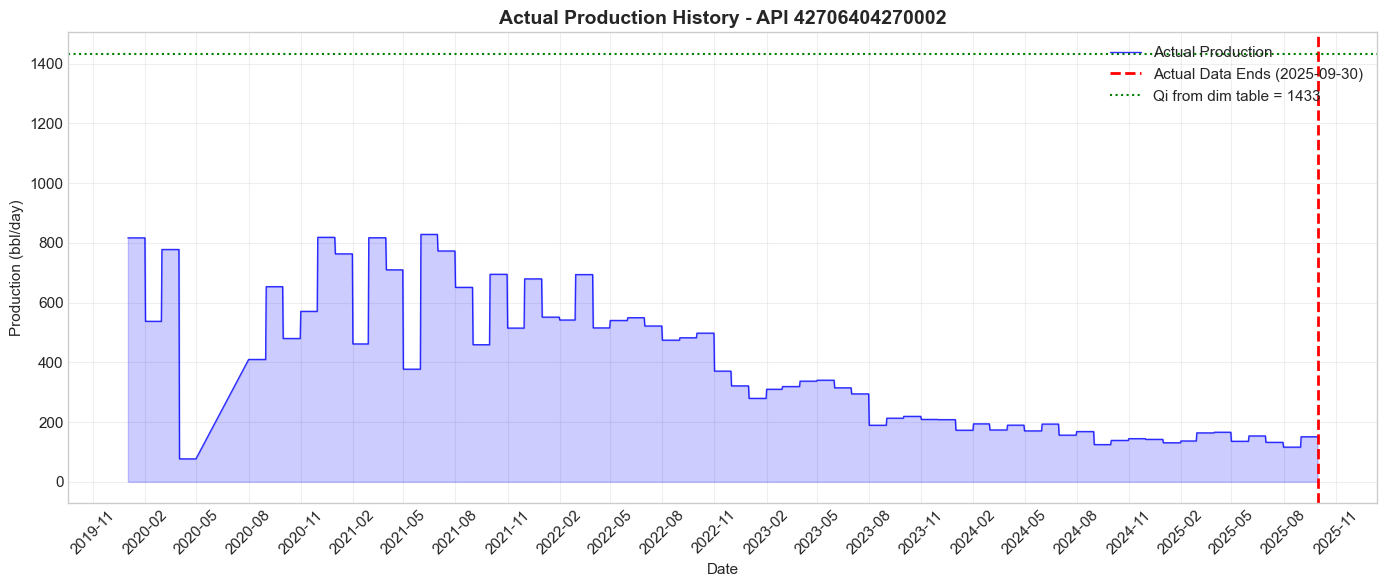

In [26]:
# Visualize actual production history
dates = [datetime.strptime(d, '%Y-%m-%d') for d in sorted(actual_production_dict.keys())]
values = [actual_production_dict[d.strftime('%Y-%m-%d')] for d in dates]

fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(dates, values, 'b-', linewidth=1, alpha=0.8, label='Actual Production')
ax.fill_between(dates, values, alpha=0.2, color='blue')

# Mark the end of actual data
ax.axvline(x=dates[-1], color='red', linestyle='--', linewidth=2, 
           label=f'Actual Data Ends ({dates[-1].strftime("%Y-%m-%d")})')

# Add Qi reference line
ax.axhline(y=TEST_QI, color='green', linestyle=':', linewidth=1.5, 
           label=f'Qi from dim table = {TEST_QI:.0f}')

ax.set_xlabel('Date')
ax.set_ylabel('Production (bbl/day)')
ax.set_title(f'Actual Production History - API {TEST_API}', fontsize=14, fontweight='bold')
ax.legend(loc='upper right')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.xticks(rotation=45)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---
## 8. Create Simulation with Historical Data + Forecast

Now we create a simulation that:
1. Uses **actual data** while available
2. Switches to **decline curve** after `latest_prod_date`

In [27]:
# Define simulation period
# Start from when we have actual data, continue 1 year past the last actual data

# Convert to datetime objects
if isinstance(TEST_PROD_START, str):
    sim_start = datetime.strptime(TEST_PROD_START, '%Y-%m-%d')
else:
    sim_start = datetime(TEST_PROD_START.year, TEST_PROD_START.month, TEST_PROD_START.day)

if isinstance(TEST_LATEST_PROD, str):
    last_data_date = datetime.strptime(TEST_LATEST_PROD, '%Y-%m-%d')
else:
    last_data_date = datetime(TEST_LATEST_PROD.year, TEST_LATEST_PROD.month, TEST_LATEST_PROD.day)

# End simulation 1 year after last actual data
sim_end = last_data_date + timedelta(days=365)

print(f" Simulation Configuration:")
print("=" * 60)
print(f"   Start Date: {sim_start.date()}")
print(f"   Last Actual Data: {last_data_date.date()} ← Historical ends here")
print(f"   End Date: {sim_end.date()} ← 1 year of forecast")
print(f"\n   Days with actual data: {(last_data_date - sim_start).days}")
print(f"   Days to forecast: {(sim_end - last_data_date).days}")

 Simulation Configuration:
   Start Date: 2010-01-01
   Last Actual Data: 2025-09-30 ← Historical ends here
   End Date: 2026-09-30 ← 1 year of forecast

   Days with actual data: 5751
   Days to forecast: 365


In [28]:
# Map play_type to well_type
def map_play_type_to_well_type(play_type: str) -> str:
    mapping = {
        'CONVENTIONAL ONSHORE': 'Conventional Onshore',
        'CONVENTIONAL OFFSHORE': 'Conventional Offshore',
        'SHALE': 'Shale Oil',
        'SHALE OIL': 'Shale Oil',
        'TIGHT': 'Tight',
        'TIGHT OIL': 'Tight Oil',
    }
    return mapping.get(str(play_type).upper(), 'Conventional Onshore')

well_type = map_play_type_to_well_type(test_well_row['well_type'])
print(f"Well type: {test_well_row['well_type']} → {well_type}")

Well type: CONVENTIONAL OFFSHORE → Conventional Offshore


In [29]:
# Create simulation runner
runner = SimulationRunner(
    total_recoverable_resources=100_000_00000,
    start_date=sim_start,
    end_date=sim_end,
    basin_name='Houston',
    market_center='Houston',
    country="UNITED STATES OF AMERICA"	,
)

print(f" SimulationRunner created")
print(f"   Total steps: {runner.total_steps}")

No reserves data available for market_center='Houston'. Reserves tracking disabled.


 SimulationRunner created
   Total steps: 6116


In [30]:
# Add well with historical data
# KEY PARAMETERS:
# - actual_production_data: Dict of actual daily production
# - last_known_qi: Production to use when switching to simulation
# - last_known_di: Decline rate to use when switching to simulation
# - last_data_date: When actual data ends

well_state = runner.add_well(
    # Identification
    api_number=TEST_API,
    
    # Well type and configuration
    well_type=well_type,
    configuration=WellConfiguration.HORIZONTAL.value,
    decline_type=DeclineType.HYPERBOLIC.value,
    
    # === Production parameters from DIMENSION TABLE ===
    initial_production=TEST_QI,  # Qi from dim table
    b_factor=TEST_B,             # b_factor from dim table
    nominal_decline_rate=TEST_DI, # Di from dim table
    
    # Dates
    production_start_date=sim_start,
    
    # Location
    location='Houston Embayment',
    basin='Gulf Coast',
    
    # === HISTORICAL PRODUCTION DATA ===
    actual_production_data=actual_production_dict,
    
    # === FALLBACK PARAMETERS (for when historical data ends) ===
    last_known_qi=TEST_LAST_BOPD,    # Use last observed production as starting Qi
    last_known_di=TEST_DI / 12,      # Convert annual to monthly decline
    last_data_date=last_data_date,   # When actual data ends
    
    # Mark as existing well
    is_new=False,
)

print(f"\n Well added to simulation:")
print(f"   ID: {well_state['id']}")
print(f"   Type: {well_state['well_type']}")
print(f"   Qi: {TEST_QI:.1f} bbl/day")
print(f"   Di: {TEST_DI:.4f} (annual)")
print(f"   b_factor: {TEST_B:.2f}")
print(f"   has_historical_data: True")


 Well added to simulation:
   ID: 2
   Type: Conventional Offshore
   Qi: 1433.2 bbl/day
   Di: 0.0069 (annual)
   b_factor: 0.35
   has_historical_data: True


In [31]:
# Run simulation
print(" Running simulation...\n")

results = []
runner.start()

step = 0
while runner.model.simulation_active:
    state = runner.step()
    step += 1
    
    sim_state = state['state']
    current_date = datetime.fromisoformat(sim_state['current_date'])
    well_data = sim_state['basin']['wells'][0]
    
    # Check if using actual data or simulation
    date_str = current_date.strftime('%Y-%m-%d')
    using_actual = date_str in actual_production_dict
    
    results.append({
        'date': current_date,
        'daily_production': well_data['daily_production'],
        'potential_production': well_data['daily_potential_production'],
        'cumulative': well_data['cumulative_production'],
        'source': 'Actual' if using_actual else 'Simulated',
    })
    
    # Progress updates at key points
    if step % 100 == 0 or step == 1:
        source_label = "ACTUAL" if using_actual else "SIMULATED"
        print(f"  Day {step:4d} ({date_str}): {well_data['daily_production']:>6.1f} bbl/day [{source_label}]")

print(f"\n Simulation complete! {step} days.")

df_results = pd.DataFrame(results)
df_results.set_index('date', inplace=True)

 Running simulation...

  Day    1 (2010-01-02):  150.7 bbl/day [SIMULATED]

📊 MONTHLY PRODUCTION BY GRADE - January 2010
   Market Center: Houston
   Heavy Sour  (hSour):             0.00 bbl
   Heavy Sweet (hSweet):            0.00 bbl
   Medium Sour (mSour):             0.00 bbl
   Medium Sweet(mSweet):            0.00 bbl
   Light Sour  (lSour):         4,672.73 bbl
   Light Sweet (lSweet):            0.00 bbl
   ────────────────────────────────────────
   TOTAL:                       4,672.73 bbl


📊 MONTHLY PRODUCTION BY GRADE - February 2010
   Market Center: Houston
   Heavy Sour  (hSour):             0.00 bbl
   Heavy Sweet (hSweet):            0.00 bbl
   Medium Sour (mSour):             0.00 bbl
   Medium Sweet(mSweet):            0.00 bbl
   Light Sour  (lSour):         4,220.53 bbl
   Light Sweet (lSweet):            0.00 bbl
   ────────────────────────────────────────
   TOTAL:                       4,220.53 bbl


📊 MONTHLY PRODUCTION BY GRADE - March 2010
   Market Cente

---
## 9. Visualize Results: Historical → Forecast Transition

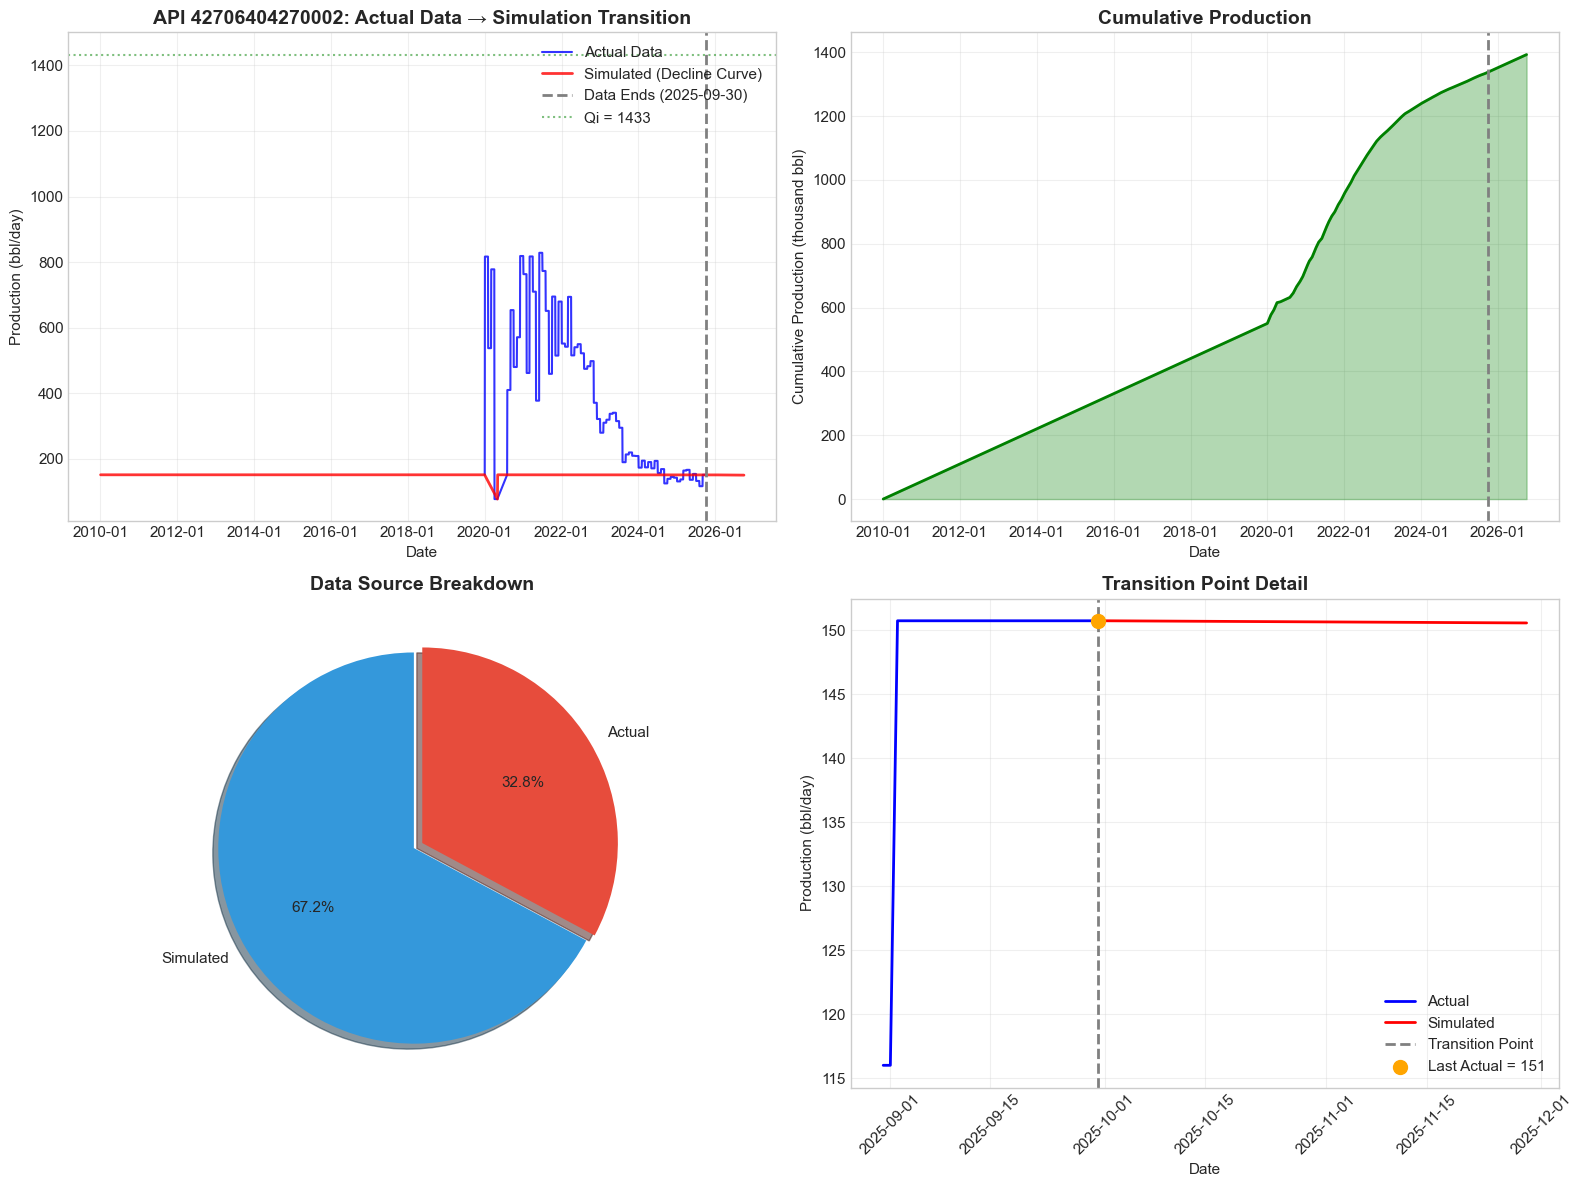


 SIMULATION SUMMARY

Data Sources:
   Days with ACTUAL data: 2008
   Days with SIMULATED data: 4108

Production Totals:
   Total Cumulative: 1,392,959 bbl
   From Actual Data: 774,010 bbl
   From Simulation: 618,949 bbl

Transition:
   Last actual production: 150.7 bbl/day
   First simulated production: 150.7 bbl/day
   Final simulated production: 149.7 bbl/day


In [32]:
# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Split data by source
actual_mask = df_results['source'] == 'Actual'
simulated_mask = df_results['source'] == 'Simulated'

# 1. Daily Production - Actual vs Simulated
ax1 = axes[0, 0]
ax1.plot(df_results[actual_mask].index, df_results[actual_mask]['daily_production'], 
         'b-', linewidth=1.5, label='Actual Data', alpha=0.8)
ax1.plot(df_results[simulated_mask].index, df_results[simulated_mask]['daily_production'], 
         'r-', linewidth=2, label='Simulated (Decline Curve)', alpha=0.8)

ax1.axvline(x=last_data_date, color='gray', linestyle='--', linewidth=2, 
            label=f'Data Ends ({last_data_date.strftime("%Y-%m-%d")})')
ax1.axhline(y=TEST_QI, color='green', linestyle=':', alpha=0.5, label=f'Qi = {TEST_QI:.0f}')

ax1.set_xlabel('Date')
ax1.set_ylabel('Production (bbl/day)')
ax1.set_title(f'API {TEST_API}: Actual Data → Simulation Transition', fontsize=14, fontweight='bold')
ax1.legend(loc='upper right')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax1.grid(True, alpha=0.3)

# 2. Cumulative Production
ax2 = axes[0, 1]
ax2.fill_between(df_results.index, df_results['cumulative'] / 1000, alpha=0.3, color='green')
ax2.plot(df_results.index, df_results['cumulative'] / 1000, 'g-', linewidth=2)
ax2.axvline(x=last_data_date, color='gray', linestyle='--', linewidth=2)
ax2.set_xlabel('Date')
ax2.set_ylabel('Cumulative Production (thousand bbl)')
ax2.set_title('Cumulative Production', fontsize=14, fontweight='bold')
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax2.grid(True, alpha=0.3)

# 3. Source breakdown (pie chart)
ax3 = axes[1, 0]
source_counts = df_results['source'].value_counts()
colors = ['#3498db', '#e74c3c']
ax3.pie(source_counts.values, labels=source_counts.index, autopct='%1.1f%%', 
        colors=colors, explode=[0.05, 0], shadow=True, startangle=90)
ax3.set_title('Data Source Breakdown', fontsize=14, fontweight='bold')

# 4. Zoom on transition point
ax4 = axes[1, 1]
# Show 30 days before and after transition
transition_start = last_data_date - timedelta(days=30)
transition_end = last_data_date + timedelta(days=60)
transition_data = df_results.loc[transition_start:transition_end]

t_actual = transition_data[transition_data['source'] == 'Actual']
t_simulated = transition_data[transition_data['source'] == 'Simulated']

ax4.plot(t_actual.index, t_actual['daily_production'], 'b-', linewidth=2, label='Actual')
ax4.plot(t_simulated.index, t_simulated['daily_production'], 'r-', linewidth=2, label='Simulated')
ax4.axvline(x=last_data_date, color='gray', linestyle='--', linewidth=2, label='Transition Point')
ax4.scatter([last_data_date], [TEST_LAST_BOPD], color='orange', s=100, zorder=5, 
            label=f'Last Actual = {TEST_LAST_BOPD:.0f}')

ax4.set_xlabel('Date')
ax4.set_ylabel('Production (bbl/day)')
ax4.set_title('Transition Point Detail', fontsize=14, fontweight='bold')
ax4.legend()
ax4.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.setp(ax4.xaxis.get_majorticklabels(), rotation=45)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary
print("\n" + "=" * 70)
print(" SIMULATION SUMMARY")
print("=" * 70)
print(f"\nData Sources:")
print(f"   Days with ACTUAL data: {actual_mask.sum()}")
print(f"   Days with SIMULATED data: {simulated_mask.sum()}")
print(f"\nProduction Totals:")
print(f"   Total Cumulative: {df_results['cumulative'].iloc[-1]:,.0f} bbl")
print(f"   From Actual Data: {df_results[actual_mask]['daily_production'].sum():,.0f} bbl")
print(f"   From Simulation: {df_results[simulated_mask]['daily_production'].sum():,.0f} bbl")
print(f"\nTransition:")
print(f"   Last actual production: {TEST_LAST_BOPD:.1f} bbl/day")
if simulated_mask.sum() > 0:
    print(f"   First simulated production: {df_results[simulated_mask]['daily_production'].iloc[0]:.1f} bbl/day")
    print(f"   Final simulated production: {df_results[simulated_mask]['daily_production'].iloc[-1]:.1f} bbl/day")

---
## 10. Summary: The Complete Workflow

```
┌─────────────────────────────────────────────────────────────────────┐
│                         DATA PREPARATION                            │
├─────────────────────────────────────────────────────────────────────┤
│ 1. DIMENSION TABLE (qi_di_b_factor_dimension.csv)                   │
│    → Get: Qi, Di, b_factor, start_year                             │
│                                                                     │
│ 2. FACT TABLE (houston_fact_combined_cleaned.csv)                   │
│    → Get: latest_production_date, actual daily production           │
│                                                                     │
│ 3. CALCULATE:                                                       │
│    days_on_production = latest_prod_date - start_year               │
│    last_bopd = last observed production value                       │
└─────────────────────────────────────────────────────────────────────┘
                                ↓
┌─────────────────────────────────────────────────────────────────────┐
│                         SIMULATION CONFIG                           │
├─────────────────────────────────────────────────────────────────────┤
│ runner.add_well(                                                    │
│     # From dimension table                                          │
│     initial_production=Qi,                                          │
│     nominal_decline_rate=Di,                                        │
│     b_factor=b_factor,                                              │
│                                                                     │
│     # From fact table - actual daily production                     │
│     actual_production_data={'2024-01-01': 500, ...},               │
│                                                                     │
│     # Fallback parameters for when data ends                        │
│     last_known_qi=last_bopd,  # Use last actual value              │
│     last_known_di=Di/12,       # Monthly decline                    │
│     last_data_date=latest_production_date,                          │
│                                                                     │
│     is_new=False,  # Existing well with history                     │
│ )                                                                   │
└─────────────────────────────────────────────────────────────────────┘
                                ↓
┌─────────────────────────────────────────────────────────────────────┐
│                         SIMULATION RUN                              │
├─────────────────────────────────────────────────────────────────────┤
│                                                                     │
│  |-------- Historical ---------|----- Forecast -----|               │
│  start_year           latest_prod_date        sim_end               │
│       ↓                      ↓                    ↓                 │
│  [Use actual values]  [Switch to decline curve simulation]          │
│                                                                     │
└─────────────────────────────────────────────────────────────────────┘
```